In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv
from cls.utils.GridUtils import VectorHash
from cls.envs.environments import GridWMEnv
from cls.vectorhash.seq_utils import *
from cls.vectorhash.assoc_utils_np import *
from cls.vectorhash.senstranspose_utils import *
from  cls.vectorhash.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d

seed = 3
rng = np.random.default_rng(seed)

CARDINAL_ACTIONS: List[Tuple[int, int]] = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # N, E, S, W

In [97]:
# Initialize a pool of environments with fixed goals per env
seed = 1
size = 5
speed = 1
n_envs = 2
rng = np.random.RandomState(seed)
env_pool = []
Np = 400
lambdas = [11,12]
input_type = "p"
observation_size = 512
start_type = "wall"

print("Setting up VectorHash")
vectorhash = VectorHash(Np=Np, lambdas=lambdas, size=size)

print("Setting up Envs")
for i in range(n_envs):
    env_i = GridWMEnv(size=size, speed=speed, seed=int(rng.randint(0, 10_000_000)), observation_size=observation_size, input_type=input_type, start_type=start_type)
    env_pool.append(env_i)

vectorhash.initiate_vectorhash(env_pool)
env = env_pool[0]
gbook = vectorhash.gbook
path_sbook = vectorhash.path_sbook
path_gbook = vectorhash.path_gbook
pbook = vectorhash.pbook
path_pbook = vectorhash.path_pbook
env_locations = vectorhash.env_locations #corner locations for each environment
Wpg = vectorhash.Wpg
Wgp = vectorhash.Wgp
thresh = vectorhash.thresh

print(vectorhash.get_loc_from_grid_state(gbook[:, 0, 0])) # location in enivronment

Setting up VectorHash
Setting up Envs
   setup scaffold
      gen_gbook_2d
(400, 265)
(265, 132, 132)
      pbook
(400, 132, 132)
      train_gcpc
(265, 400)
   setup envs
   initialize envs vh
(0, 0)


In [98]:
def recall(Wpp, obs):
    pnext = nonlin(Wpp@obs, thresh=thresh)
    p = np.copy(pnext)
    gin = Wgp@p
    Ng = gin.shape[0]
    ls = [l**2 for l in lambdas]
    i=0
    gout = np.zeros(gin.shape)
    for j in ls:
        gmod = gin[i:i+j]
        maxes = gmod.argmax()
        gout[maxes+i] = 1
        i=i+j
    loc = vectorhash.get_loc_from_grid_state(gout)
    return loc

In [99]:
Wpp = np.random.rand(pbook.shape[0], pbook.shape[0])
n_steps = 10
pin_successes = []
pout_successes = []
total_steps = []
total_successes = []
goal_reached = []
nav_steps = []

for i in range(100):
    pins = []
    pouts = []
    rand = lambda: np.random.randint(0, len(CARDINAL_ACTIONS))
    positions = []

    env.reset()
    cur, goal = env.current_location, env.goal_location
    positions.append(cur)

    total_steps.append(n_steps)
    goal_reached.append(False)
    successes = 0
    nav_step_count = 0

    for step in range(n_steps):
        best_vecs = env.best_action_to_goal(return_all=True)
        currin = np.array(env.current_location)
        pin = env.obs()
        best_location = currin + np.array(best_vecs[0])

        vec = CARDINAL_ACTIONS[rand()]
        loc = np.array(recall(Wpp, pin))
        action = tuple(loc - currin)
        if action in CARDINAL_ACTIONS:
            vec = action
            nav_step_count += 1
        cur, goal, obs, reward = env.step(vec)

        pins.append(pin)
        pouts.append(obs)
        positions.append(cur)

        loc = np.array(recall(Wpp, obs))
        if np.all(loc == best_location):
            successes += 1

        if cur == goal:
            pin_successes.extend(pins)
            pout_successes.extend(pouts)

            pins = np.stack(pin_successes)
            pouts = np.stack(pout_successes)

            # remove duplicate pins
            # _, idxs = np.unique(pins, axis=0, return_index=True)
            # pins = pins[idxs]
            # pouts = pouts[idxs]

            pins = pins.T
            pouts = pouts.T

            pin_inv = np.linalg.pinv(pins)
            Wpp = np.einsum('ij, jk -> ik', pouts, pin_inv)

            # Npatts = pins.shape[1]
            # Wpp = (1/Npatts)*np.einsum('ij, lj -> il', pouts, pins)  

            total_steps[-1] = step
            goal_reached[-1] = True
            break

    total_successes.append(successes)
    nav_steps.append(nav_step_count)

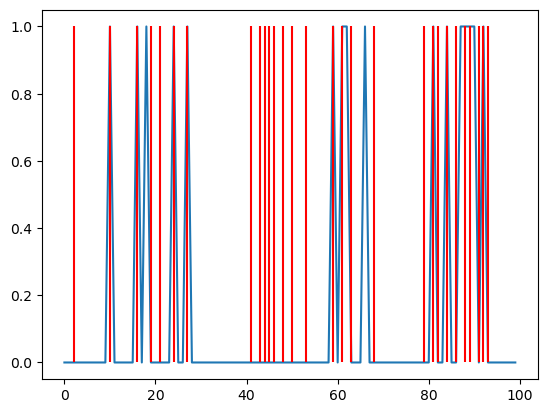

In [100]:
plt.plot(total_successes)
#plot a vertical line for every time goal_reached is true
plt.vlines(np.where(goal_reached)[0], 0, 1, colors='r')
plt.show()


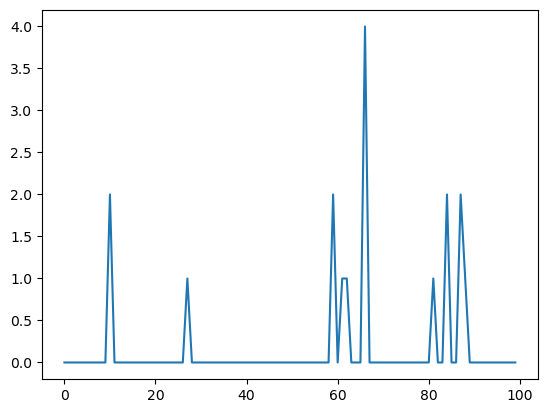

In [101]:
plt.plot(nav_steps)
plt.show()

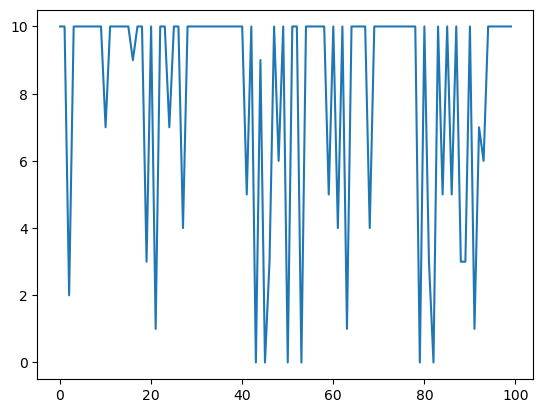

In [102]:
plt.plot(total_steps)
plt.show()
